# Context

in this notebook we are trying to optimise the best model form the selection phase to better target each different phylum. In that sense we are splitting the training and the modeling for the different phylumns  

# Imports

In [1]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [3]:
# With colab
folder_path = '/content/rare_species 1/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

In [4]:
print(f"the diferent Phylum are: \n{meta['phylum'].unique()}")
print(f"each phylum contains :  \n{meta['phylum'].value_counts()}")

print(f"their is {meta['family'].nunique()} different families")

meta

the diferent Phylum are: 
['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']
each phylum contains :  
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64
their is 202 different families


,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...


# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.<br>
(we repeat this proses in each notebook only because we are using colab)

In [5]:
# With colab
current_locations = '/content/rare_species 1/rare_species 1'

# with vscode
# current_locations = '../data/rare_species 1'

for _, row in meta.iterrows():

    phylum = row['phylum']
    file_path = row['file_path']


    file_location = os.path.join(current_locations, file_path)

    # create a a detination folder keeping the subfolder structure

        # with colab
    target_folder = os.path.join(phylum, os.path.dirname(file_path))

        # with vscode
    # target_folder = os.path.join("../data" , phylum, os.path.dirname(file_path))

    os.makedirs(target_folder, exist_ok=True)  # Make sure the folder exists

    # Final destination path
    destination = os.path.join(target_folder, os.path.basename(file_path))

    # Copy the file if it exists
    if os.path.exists(file_location):
        shutil.copy2(file_location, destination)
    else:
        print(f"Couldn't find the file: {file_location}")

# Train Val Split

In [6]:
# with colab
path_phylum_chordata = "/content/chordata"


# with vscode
# path_phylum_chordata = "../data/chordata"


image_size = (224, 224)
seed = 42
batch_size = 32


train_ds_chordata, val_ds_chordata = keras.utils.image_dataset_from_directory(
    path_phylum_chordata,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 9952 files belonging to 166 classes.
Using 7962 files for training.
Using 1990 files for validation.


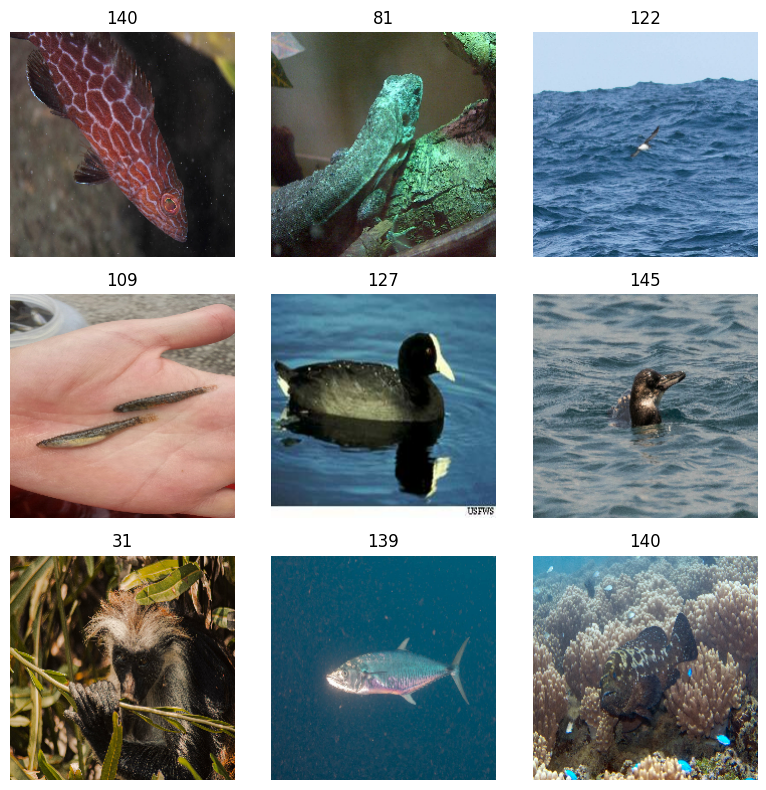

In [7]:
def display_images(train_ds):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(8, 8))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        plt.tight_layout()
        plt.show()

display_images(train_ds_chordata)

# Augmentation layer

In [8]:
data_augmentation_layers = keras.Sequential([

    # apply any kind of kera preprocessing randomly
    layers.RandAugment(value_range=(0, 255), num_ops=2),

    # change the image by moving or zooming in
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), # 20 percent rotation
    layers.RandomZoom(0.2), # 20 percent rotation


    # change the image rgbs --> contrast and brightness
    layers.RandomContrast(0.2, value_range=(0, 255)), # change by 20%
    layers.RandomBrightness(0.2, (0, 255)), # cahnge by 20 %

    # adds noise to the images to prevent overfitting (blurry filter)
    layers.GaussianNoise(0.05),

    ])

# Model

In [35]:
## to be adapted to the new dataset
def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation_layers(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x) # to avoid over fitting
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.base_model = base_model # save thee base model to be able to call it back when fine tunning

    return model

# Run and evaluation

## first run

In [38]:
model_athoropa = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=166)
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000, # means it will be updated every 4 epochs
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_athoropa.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_athoropa.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_chordata,
)


<ipython-input-35-169ad977408e>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - acc: 0.0642 - loss: 5.2883
Epoch 1: val_acc improved from -inf to 0.28241, saving model to best_model_chordata.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 216s 662ms/step - acc: 0.0644 - loss: 5.2863 - val_acc: 0.2824 - val_loss: 3.3495
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - acc: 0.1902 - loss: 3.8648
Epoch 2: val_acc improved from 0.28241 to 0.32915, saving model to best_model_chordata.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 203s 666ms/step - acc: 0.1903 - loss: 3.8646 - val_acc: 0.3291 - val_loss: 3.0089
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - acc: 0.2397 - loss: 3.5080
Epoch 3: val_acc improved from 0.32915 to 0.36734, saving model to best_model_chordata.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 203s 670ms/step - acc: 0.2397 - loss: 3.5080 - val_acc: 0.3673 - val_loss: 2.8223
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - acc: 0.2624 - loss: 3.2989
Epoch 4: val_acc improved from 0.36734 to 0.37538, saving m

## Fine tunning

In [39]:
fine_tune_epochs = 5

# we recall the model only this time we allow it to change the layers in the base model
# we load the weights of the best reuslt of the first training
fine_tune_model = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=166)
fine_tune_model.load_weights("best_model_chordata.keras")

# only unfreeze the lasts layer of the pretrained model here 20
fine_tune_model.base_model.trainable = True
for layer in fine_tune_model.base_model.layers[:-20]:
    layer.trainable = False


fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # lower learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

fine_tune_model.fit(
    train_ds_chordata,
    epochs=fine_tune_epochs,
    validation_data=val_ds_chordata,
    callbacks=callbacks
)


<ipython-input-35-169ad977408e>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - acc: 0.3064 - loss: 3.0861
Epoch 1: val_acc improved from 0.43920 to 0.44070, saving model to best_model_chordata.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 178s 680ms/step - acc: 0.3065 - loss: 3.0856 - val_acc: 0.4407 - val_loss: 2.3991
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - acc: 0.3450 - loss: 2.8217
Epoch 2: val_acc improved from 0.44070 to 0.45276, saving model to best_model_chordata.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 195s 652ms/step - acc: 0.3451 - loss: 2.8215 - val_acc: 0.4528 - val_loss: 2.3555
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - acc: 0.3704 - loss: 2.6733
Epoch 3: val_acc improved from 0.45276 to 0.46131, saving model to best_model_chordata.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 201s 650ms/step - acc: 0.3704 - loss: 2.6732 - val_acc: 0.4613 - val_loss: 2.3097
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - acc: 0.3799 - loss: 2.5585
Epoch 4: val_acc improved from 0.46131 to 0.46633, saving mo

# Model Evaluation

In [40]:
best_model_fine_tuned = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_fine_tuned.predict(val_ds_chordata)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_chordata], axis=0)

print(classification_report(y_true, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 481ms/step
              precision    recall  f1-score   support

           0       0.40      0.45      0.43        22
           1       0.36      0.22      0.28        18
           2       0.83      0.38      0.53        13
           3       0.25      0.33      0.29         6
           4       0.67      0.50      0.57         4
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        13
           7       0.25      0.20      0.22         5
           8       0.51      0.58      0.54        38
           9       0.62      0.36      0.45        14
          10       0.57      0.50      0.53         8
          11       0.50      0.43      0.46        14
          12       0.50      0.67      0.57         6
          13       0.36      0.35      0.36        37
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        11
          16       0.11      0.33      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
